In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Dataset Definition
class GaussianBumpDataset(Dataset):
    def __init__(self, num_samples=1000, grid_size=28, sigma=1.0):
        self.num_samples = num_samples
        self.grid_size = grid_size
        self.sigma = sigma
        self.data = []
        self.targets = []

        for _ in range(num_samples):
            x, y = np.random.uniform(0, grid_size, size=2)  # Use continuous values for x and y
            xv, yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
            gaussian_image = 1.0 - np.exp(-((xv - x) ** 2 + (yv - y) ** 2) / (2 * sigma ** 2))

            self.data.append(np.array([x, y]))  # Store x and y as a 2D vector
            self.targets.append(gaussian_image)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0)

# Model Definition with CNN Decoder
class CNNDecoderWithActivations(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, n_hidden_layers=4):
        super(CNNDecoderWithActivations, self).__init__()
        layers = []
        self.activations = []

        # First layer: decompress input_size to hidden_size channels and increase spatial size to 7x7
        layers.append(nn.ConvTranspose2d(input_size, hidden_size, kernel_size=7, stride=1, padding=0))
        layers.append(nn.ReLU())
        current_size = 7  # Starting spatial size after first layer

        # Calculate the number of layers needed to upscale to 28x28
        upsample_layers_needed = max(0, int(np.log2(28 / current_size)))

        for i in range(n_hidden_layers):
            if current_size < 28 and upsample_layers_needed > 0:
                # Upsampling layer to increase spatial dimensions
                layers.append(nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1))
                current_size *= 2  # Update current spatial size
                upsample_layers_needed -= 1
            else:
                # Maintain spatial dimensions
                layers.append(nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())

        # Final layer: map to 1 channel with correct output size
        layers.append(nn.ConvTranspose2d(hidden_size, 1, kernel_size=3, stride=1, padding=1))
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        self.activations = []  # Clear previous activations
        x = x.unsqueeze(-1).unsqueeze(-1)
        for layer in self.decoder:
            x = layer(x)
            # Store activations only after ReLU layers
            if isinstance(layer, nn.ReLU):
                self.activations.append(x.clone().detach())
        return x

# Training Setup

def train_model(model, dataloader, num_epochs=20, learning_rate=1e-3, print_gradients=False, grad_print_interval=1):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    avg_losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Optional: Print gradients per layer
            if print_gradients and (epoch % grad_print_interval == 0) and (batch_idx == 0):
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}:")
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_norm = param.grad.data.norm(2).item()
                        print(f"  Layer {name}: Gradient Norm = {grad_norm:.6f}")
                    else:
                        print(f"  Layer {name}: No gradient")
            
            optimizer.step()
            running_loss += loss.item()
    
        avg_loss = running_loss / len(dataloader)
        avg_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        # scheduler.step(avg_loss)
    return avg_losses

# Visualization and Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    mse_loss = 0.0
    criterion = nn.MSELoss()
    num_samples = 4
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            outputs = model(inputs)
            mse_loss += criterion(outputs, targets).item() * inputs.size(0)

            if batch_idx < num_samples:
                sampled_inputs.append(inputs)
                sampled_targets.append(targets)
                sampled_outputs.append(outputs)

    mse_loss /= len(dataloader.dataset)
    print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")

    # Plot sampled images
    for i in range(num_samples):
        input_coords = sampled_inputs[i][0].cpu().numpy()
        target_image = sampled_targets[i][0].cpu().squeeze().numpy()
        output_image = sampled_outputs[i][0].cpu().squeeze().numpy()

        x, y = input_coords[0], input_coords[1]

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Target Image")
        plt.imshow(target_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(output_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.show()

In [ ]:
# Hyperparameters
input_size = 2
hidden_size = 256
n_hidden_layers = 10
batch_size = 32
num_epochs = 100
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and DataLoader
dataset = GaussianBumpDataset(num_samples=1000, grid_size=28)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Model Initialization
model = CNNDecoderWithActivations(input_size=input_size, hidden_size=hidden_size, n_hidden_layers=n_hidden_layers)

# Train the model
avg_loss_list = train_model(model, dataloader, num_epochs=num_epochs, learning_rate=learning_rate, print_gradients=False)

/om2/user/qiyao/.conda/envs/env1/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/om2/user/qiyao/.conda/envs/env1/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/100], Loss: 0.2064
Epoch [2/100], Loss: 0.0150
Epoch [3/100], Loss: 0.0047
Epoch [4/100], Loss: 0.0042
Epoch [5/100], Loss: 0.0041
Epoch [6/100], Loss: 0.0042
Epoch [7/100], Loss: 0.0040
Epoch [8/100], Loss: 0.0047
Epoch [9/100], Loss: 0.0039
Epoch [10/100], Loss: 0.0037
Epoch [11/100], Loss: 0.0036
Epoch [12/100], Loss: 0.0036
Epoch [13/100], Loss: 0.0035
Epoch [14/100], Loss: 0.0036
Epoch [15/100], Loss: 0.0036
Epoch [16/100], Loss: 0.0034
Epoch [17/100], Loss: 0.0045
Epoch [18/100], Loss: 0.0037
Epoch [19/100], Loss: 0.0037
Epoch [20/100], Loss: 0.0035
Epoch [21/100], Loss: 0.0034
Epoch [22/100], Loss: 0.0033
Epoch [23/100], Loss: 0.0033
Epoch [24/100], Loss: 0.0033
Epoch [25/100], Loss: 0.0031
Epoch [26/100], Loss: 0.0032
Epoch [27/100], Loss: 0.0029
Epoch [28/100], Loss: 0.0029
Epoch [29/100], Loss: 0.0031
Epoch [30/100], Loss: 0.0029
Epoch [31/100], Loss: 0.0029
Epoch [32/100], Loss: 0.0025
Epoch [33/100], Loss: 0.0024
Epoch [34/100], Loss: 0.0024
Epoch [35/100], Loss: 0

Mean Squared Error on Evaluation: 0.0001


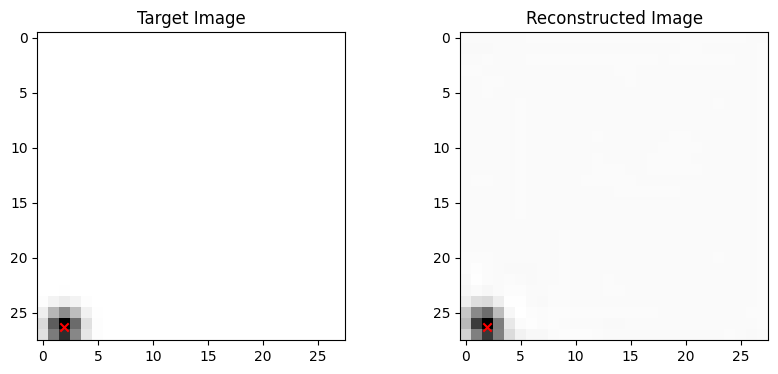

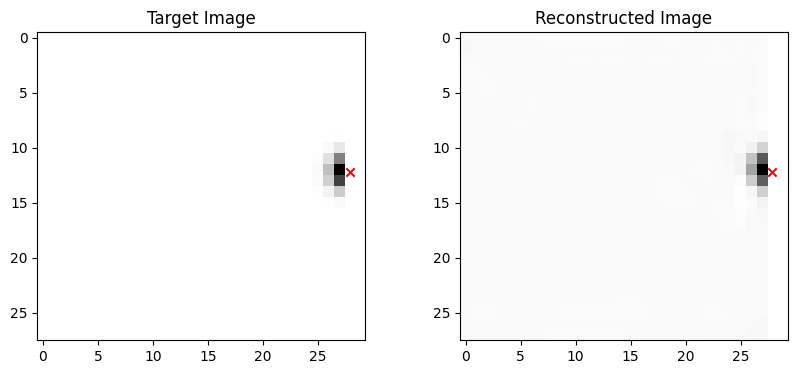

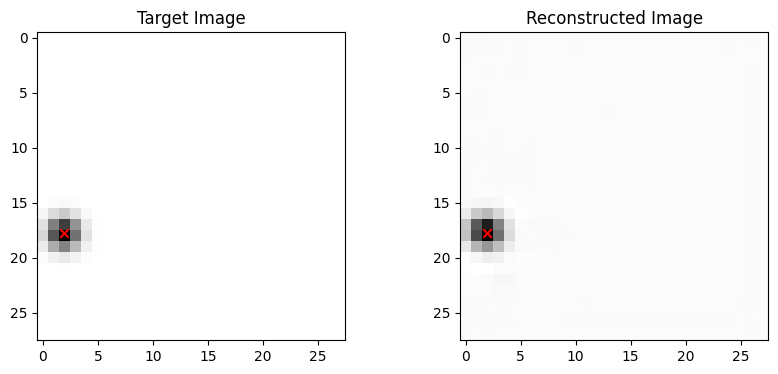

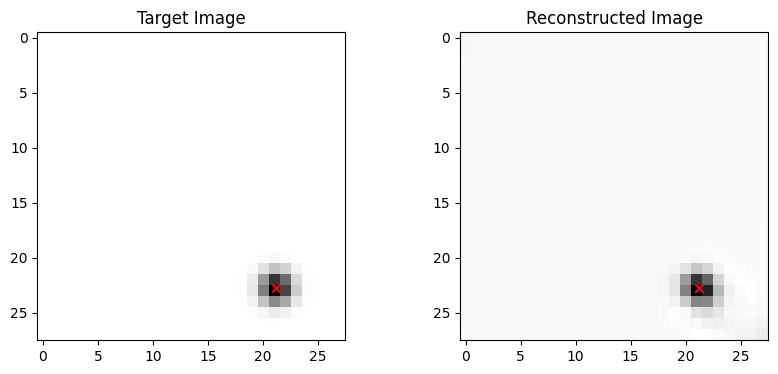

In [3]:
def evaluate_model(model, dataloader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Ensure the model is on the same device as during training

    mse_loss = 0.0
    criterion = nn.MSELoss()
    num_samples = 4
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
            outputs = model(inputs)
            mse_loss += criterion(outputs, targets).item() * inputs.size(0)

            if batch_idx < num_samples:
                sampled_inputs.append(inputs.cpu())  # Store on CPU for visualization
                sampled_targets.append(targets.cpu())  # Store on CPU for visualization
                sampled_outputs.append(outputs.cpu())  # Store on CPU for visualization

    mse_loss /= len(dataloader.dataset)
    print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")

    # Plot sampled images
    for i in range(num_samples):
        input_coords = sampled_inputs[i][0].numpy()
        target_image = sampled_targets[i][0].squeeze().numpy()
        output_image = sampled_outputs[i][0].squeeze().numpy()

        x, y = input_coords[0], input_coords[1]

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Target Image")
        plt.imshow(target_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(output_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.show()

# Evaluate the model and visualize some samples
evaluate_model(model, dataloader)

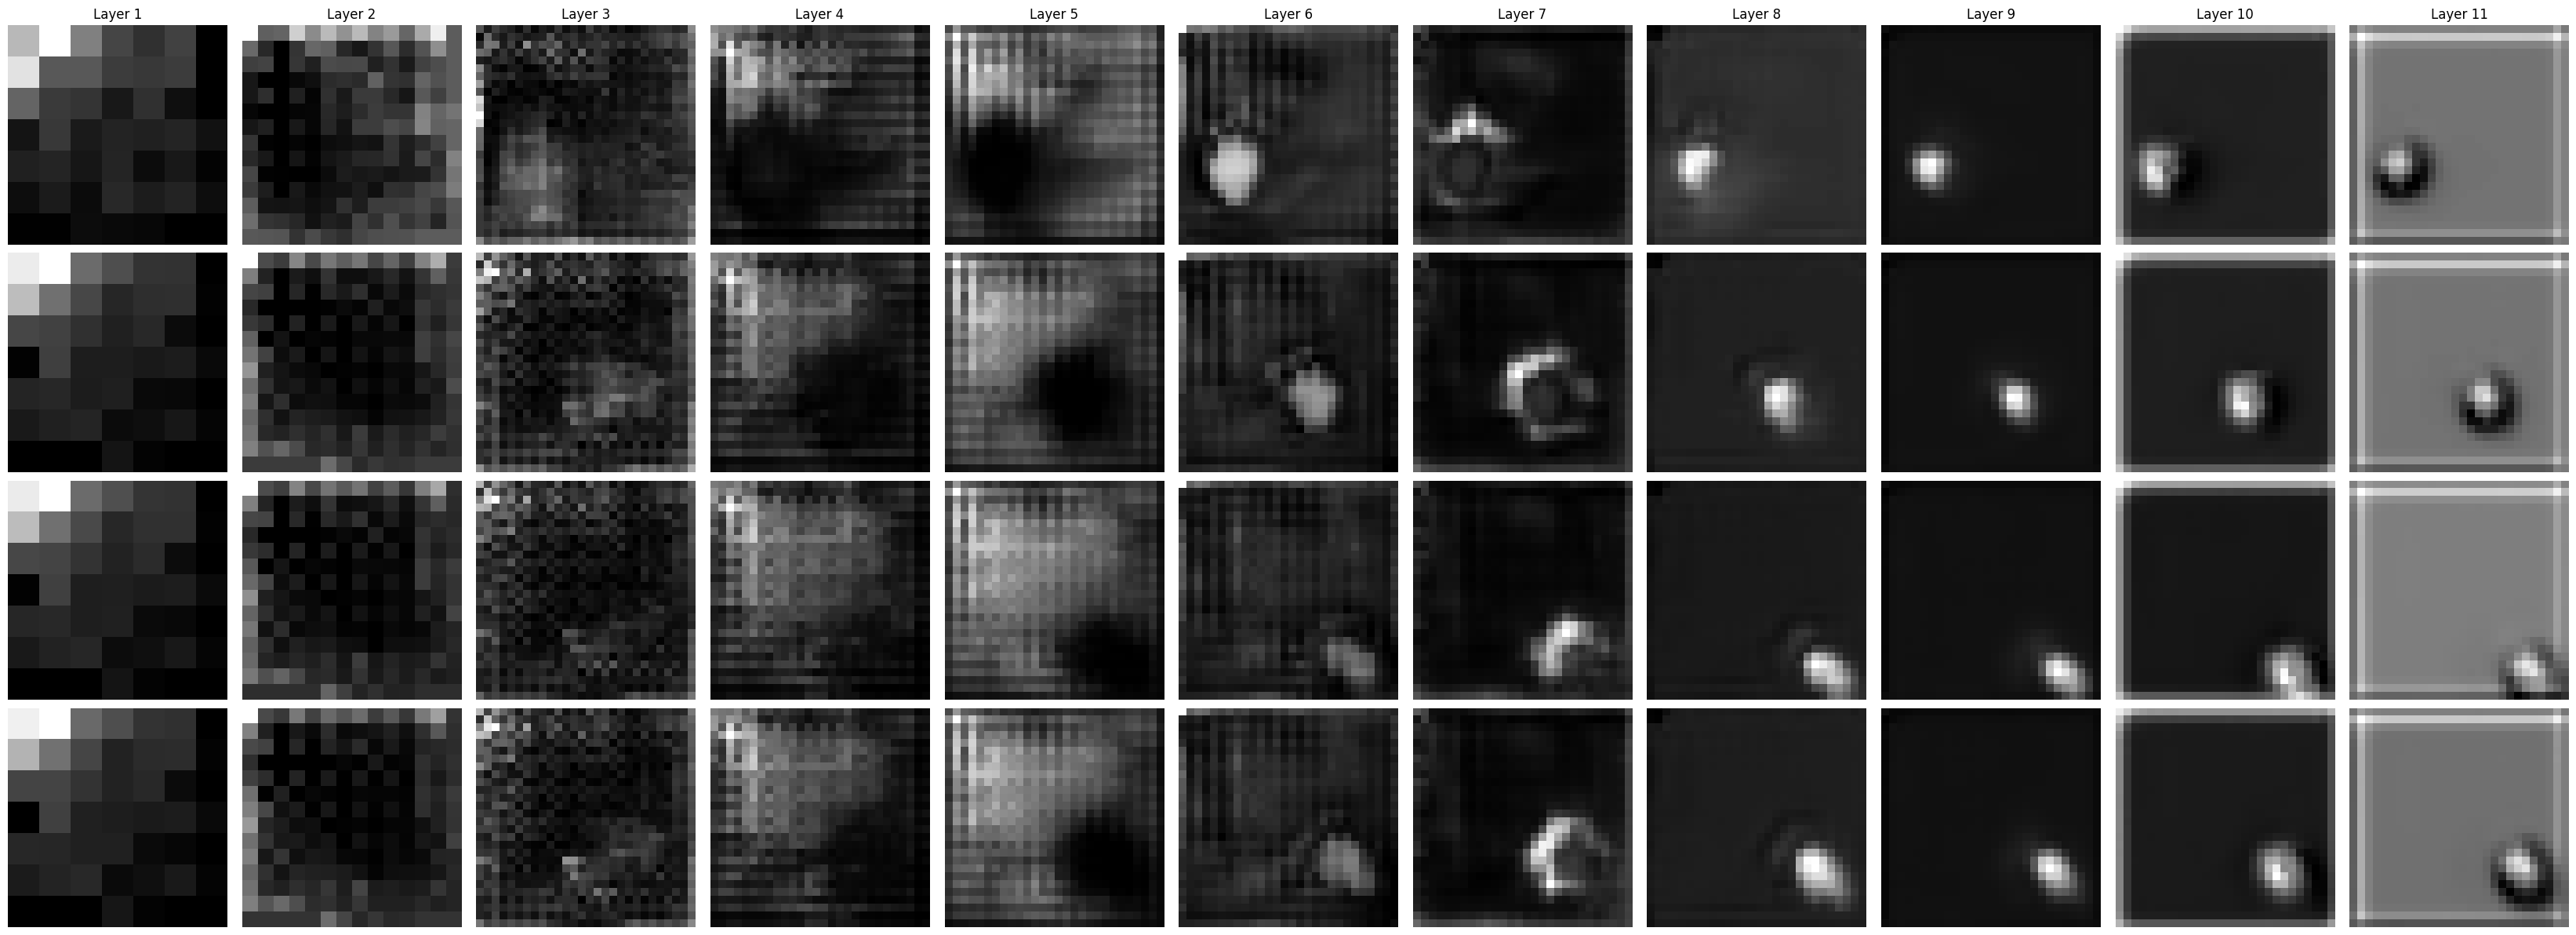

In [4]:
def visualize_layers(model, train_dataloader, device=torch.device('cuda')):
    model.eval()
    criterion = nn.MSELoss()
    num_samples = 4  # Number of samples to visualize
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []
    sampled_activations = []

    with torch.no_grad():
        # Collect samples from training data
        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Collect activations
            activations = [activation.clone().detach().cpu() for activation in model.activations]
            if len(sampled_inputs) < num_samples:
                sampled_inputs.append(inputs.cpu())
                sampled_targets.append(targets.cpu())
                sampled_outputs.append(outputs.cpu())
                # Store activations for the first sample in the batch
                sampled_activation_per_sample = [activation[0] for activation in activations]  # List of tensors
                sampled_activations.append(sampled_activation_per_sample)
            else:
                break  # We have collected enough samples

    # Now we have num_samples samples and their activations
    num_layers = len(sampled_activations[0])  # Number of activations collected

    # Create a grid of plots
    fig, axes = plt.subplots(num_samples, num_layers, figsize=(num_layers * 3, num_samples * 3))

    for i in range(num_samples):
        activations = sampled_activations[i]
        for j in range(num_layers):
            activation = activations[j]  # Shape: (channels, height, width)
            # Compute mean over channels to get a single image
            activation_image = activation.mean(dim=0).numpy()
            # Normalize the activation image for better visualization
            activation_image -= activation_image.min()
            activation_image /= activation_image.max() + 1e-8  # Avoid division by zero
            ax = axes[i, j]
            ax.imshow(activation_image, cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Layer {j+1}')
    plt.tight_layout()
    plt.show()

visualize_layers(model, dataloader)

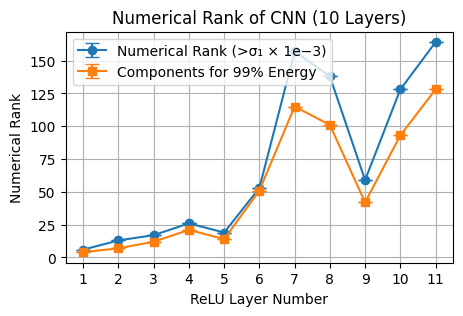

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the model is in evaluation mode
model.eval()

# Create the test dataset and DataLoader
test_dataset = GaussianBumpDataset(num_samples=1000, grid_size=28)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize lists to store ranks for each batch
effective_ranks_per_layer = []
ranks_99_per_layer = []
layer_numbers = None

# Subsample limit to optimize computation
max_samples = 1000  # Adjust as needed based on available memory

for inputs, _ in test_loader:
    inputs = inputs.to(device)
    # Perform forward pass and collect activations
    outputs = model(inputs)
    activations = model.activations

    if layer_numbers is None:
        num_layers = len(activations)
        layer_numbers = list(range(1, num_layers + 1))

    batch_effective_ranks = []
    batch_ranks_99 = []

    for activation in activations:
        activation = activation.detach().cpu()

        # Reshape activations to (n_samples, n_features)
        batch_size_, channels, height, width = activation.shape
        # (batch_size, channels, height*width)
        activation = activation.view(batch_size_, -1)
        # print('activation shape: ', activation.shape)
        # activation = activation.permute(0, 2, 1)  # (batch_size, height*width, channels)
        # activation = activation.reshape(-1, channels)  # (batch_size * height * width, channels)

        # Subsample activations if necessary
        idx = torch.randperm(activation.shape[1])[:max_samples]
        activation = activation[:, idx]

        # Center the activations
        activation_centered = activation - activation.mean(dim=0)

        # Convert to NumPy array
        activation_centered = activation_centered.numpy()

        # Compute the sample covariance matrix
        n_samples = activation_centered.shape[0]
        covariance_matrix = (1.0 / n_samples) * np.dot(activation_centered.T, activation_centered)

        # Compute eigenvalues of the covariance matrix
        eigenvalues = np.linalg.eigvalsh(covariance_matrix)
        eigenvalues = eigenvalues[::-1]  # Sort in descending order

        # Threshold σ = σ₁ × 1e−3
        sigma = eigenvalues[0] * 1e-3

        # Compute numerical rank
        effective_rank = np.sum(eigenvalues > sigma)
        batch_effective_ranks.append(effective_rank)

        # Compute components for 99% energy
        total_energy = np.sum(eigenvalues)
        cumulative_energy = np.cumsum(eigenvalues)
        num_components_99 = np.searchsorted(cumulative_energy, 0.99 * total_energy) + 1
        batch_ranks_99.append(num_components_99)

    effective_ranks_per_layer.append(batch_effective_ranks)
    ranks_99_per_layer.append(batch_ranks_99)

# Convert lists to NumPy arrays
effective_ranks_per_layer = np.array(effective_ranks_per_layer)  # (num_batches, num_layers)
ranks_99_per_layer = np.array(ranks_99_per_layer)  # (num_batches, num_layers)

# Calculate mean and standard deviation
mean_effective_ranks = np.mean(effective_ranks_per_layer, axis=0)
std_effective_ranks = np.std(effective_ranks_per_layer, axis=0)
mean_ranks_99 = np.mean(ranks_99_per_layer, axis=0)
std_ranks_99 = np.std(ranks_99_per_layer, axis=0)

# Plotting the ranks with error bars
plt.figure(figsize=(5, 3))
plt.errorbar(layer_numbers, mean_effective_ranks, yerr=std_effective_ranks, fmt='-o', capsize=5,
             label='Numerical Rank (>σ₁ × 1e−3)')
plt.errorbar(layer_numbers, mean_ranks_99, yerr=std_ranks_99, fmt='-s', capsize=5,
             label='Components for 99% Energy')
plt.title('Numerical Rank of CNN (10 Layers)')
plt.xlabel('ReLU Layer Number')
plt.ylabel('Numerical Rank')
plt.xticks(layer_numbers)
plt.legend()
plt.grid(True)
plt.show()


# Held-out

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np

import torch
from torch.utils.data import Dataset
import numpy as np

# class GaussianBumpDatasetSquare(Dataset):
#     def __init__(self, num_samples=1000, grid_size=28, sigma=1.0, holdout_center=True, only_holdout=False, heldout_range=[10,18]):
#         self.num_samples = num_samples
#         self.grid_size = grid_size
#         self.sigma = sigma
#         self.holdout_center = holdout_center
#         self.only_holdout = only_holdout
#         self.data = []
#         self.targets = []

#         lb, ub = heldout_range

#         holdout_min = lb
#         holdout_max = ub

#         for _ in range(num_samples):
#             while True:
#                 x, y = np.random.randint(0, grid_size, size=2)
#                 if self.holdout_center and (holdout_min <= x <= holdout_max and holdout_min <= y <= holdout_max):
#                     continue
#                 if self.only_holdout and not (holdout_min <= x <= holdout_max and holdout_min <= y <= holdout_max):
#                     continue
#                 break

#             xv, yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
#             gaussian_image = 1.0 - np.exp(-((xv - x) ** 2 + (yv - y) ** 2) / (2 * sigma ** 2))

#             self.data.append(np.array([x, y]))
#             self.targets.append(gaussian_image)

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0)

import torch
from torch.utils.data import Dataset
import numpy as np

class GaussianBumpDatasetSquare(Dataset):
    def __init__(self, num_samples=1000, grid_size=28, sigma=1.0, holdout_center=True, 
                 only_holdout=False, heldout_range=[10,18]):
        self.num_samples = num_samples
        self.grid_size = grid_size
        self.sigma = sigma
        self.holdout_center = holdout_center
        self.only_holdout = only_holdout
        self.data = []
        self.targets = []
        
        lb, ub = heldout_range
        self.holdout_min = lb
        self.holdout_max = ub
        
        # Pre-compute the meshgrid for efficiency
        self.xv, self.yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
        
        # Generate all samples at once
        self._generate_samples()
    
    def _generate_samples(self):
        if self.only_holdout:
            # Generate points directly within the holdout range
            x = np.random.randint(self.holdout_min, self.holdout_max + 1, size=self.num_samples)
            y = np.random.randint(self.holdout_min, self.holdout_max + 1, size=self.num_samples)
        elif self.holdout_center:
            x = []
            y = []
            while len(x) < self.num_samples:
                # Generate a batch of points
                batch_size = min(self.num_samples * 2, 10000)  # Generate points in batches
                x_batch = np.random.randint(0, self.grid_size, size=batch_size)
                y_batch = np.random.randint(0, self.grid_size, size=batch_size)
                
                # Create mask for valid points (outside holdout region)
                valid_mask = ~((x_batch >= self.holdout_min) & (x_batch <= self.holdout_max) & 
                              (y_batch >= self.holdout_min) & (y_batch <= self.holdout_max))
                
                # Add valid points to our lists
                x.extend(x_batch[valid_mask])
                y.extend(y_batch[valid_mask])
            
            # Trim to exact size needed
            x = x[:self.num_samples]
            y = y[:self.num_samples]
            
            # Convert back to numpy arrays
            x = np.array(x)
            y = np.array(y)
        else:
            # Generate points anywhere in the grid
            x = np.random.randint(0, self.grid_size, size=self.num_samples)
            y = np.random.randint(0, self.grid_size, size=self.num_samples)
        
        # Generate Gaussian images
        for i in range(self.num_samples):
            gaussian_image = 1.0 - np.exp(-((self.xv - x[i])**2 + (self.yv - y[i])**2) / 
                                        (2 * self.sigma**2))
            self.data.append(np.array([x[i], y[i]]))
            self.targets.append(gaussian_image)

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float32), 
                torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0))
    
class GaussianBumpDatasetCross(Dataset):
    def __init__(self, num_samples=1000, grid_size=28, sigma=1.0, holdout_cross=True, only_holdout=False, heldout_range=[11,17]):
        self.num_samples = num_samples
        self.grid_size = grid_size
        self.sigma = sigma
        self.holdout_cross = holdout_cross
        self.only_holdout = only_holdout
        self.data = []
        self.targets = []
        lb, ub = heldout_range
        lower_bound = lb
        upper_bound = ub

        for _ in range(num_samples):
            while True:
                x, y = np.random.randint(0, grid_size, size=2)
                if self.holdout_cross and (lower_bound <= x < upper_bound or lower_bound <= y < upper_bound):
                    continue
                if self.only_holdout and not (lower_bound <= x < upper_bound or lower_bound <= y < upper_bound):
                    continue
                break

            # gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * sigma ** 2))
            # gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * sigma ** 2))

            xv, yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
            gaussian_image = 1.0 - np.exp(-((xv - x) ** 2 + (yv - y) ** 2) / (2 * sigma ** 2))

            self.data.append(np.array([x, y]))
            self.targets.append(gaussian_image)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        input_coords = torch.tensor(self.data[idx], dtype=torch.float32)  # 2D vector [x, y]
        target_image = torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return input_coords, target_image
    
# Model Definition with CNN Decoder
class CNNDecoderWithActivations(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, n_hidden_layers=4):
        super(CNNDecoderWithActivations, self).__init__()
        layers = []
        self.activations = []

        # First layer: decompress input_size to hidden_size channels and increase spatial size to 7x7
        layers.append(nn.ConvTranspose2d(input_size, hidden_size, kernel_size=7, stride=1, padding=0))
        layers.append(nn.ReLU())
        current_size = 7  # Starting spatial size after first layer

        # Calculate the number of layers needed to upscale to 28x28
        upsample_layers_needed = max(0, int(np.log2(28 / current_size)))

        for i in range(n_hidden_layers):
            if current_size < 28 and upsample_layers_needed > 0:
                # Upsampling layer to increase spatial dimensions
                layers.append(nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1))
                current_size *= 2  # Update current spatial size
                upsample_layers_needed -= 1
            else:
                # Maintain spatial dimensions
                layers.append(nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())

        # Final layer: map to 1 channel with correct output size
        layers.append(nn.ConvTranspose2d(hidden_size, 1, kernel_size=3, stride=1, padding=1))
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        self.activations = []  # Clear previous activations
        x = x.unsqueeze(-1).unsqueeze(-1)
        for layer in self.decoder:
            x = layer(x)
            # Store activations only after ReLU layers
            if isinstance(layer, nn.ReLU):
                self.activations.append(x.clone().detach())
        return x

# Training Setup

def train_model(model, dataloader, num_epochs=20, learning_rate=1e-3, print_gradients=False, grad_print_interval=1):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    avg_losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Optional: Print gradients per layer
            if print_gradients and (epoch % grad_print_interval == 0) and (batch_idx == 0):
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}:")
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_norm = param.grad.data.norm(2).item()
                        print(f"  Layer {name}: Gradient Norm = {grad_norm:.6f}")
                    else:
                        print(f"  Layer {name}: No gradient")
            
            optimizer.step()
            running_loss += loss.item()
    
        avg_loss = running_loss / len(dataloader)
        avg_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        # scheduler.step(avg_loss)
    return avg_losses

# Visualization and Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    mse_loss = 0.0
    criterion = nn.MSELoss()
    num_samples = 4
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            outputs = model(inputs)
            mse_loss += criterion(outputs, targets).item() * inputs.size(0)

            if batch_idx < num_samples:
                sampled_inputs.append(inputs)
                sampled_targets.append(targets)
                sampled_outputs.append(outputs)

    mse_loss /= len(dataloader.dataset)
    print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")

    # Plot sampled images
    for i in range(num_samples):
        input_coords = sampled_inputs[i][0].cpu().numpy()
        target_image = sampled_targets[i][0].cpu().squeeze().numpy()
        output_image = sampled_outputs[i][0].cpu().squeeze().numpy()

        x, y = input_coords[0], input_coords[1]

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Target Image")
        plt.imshow(target_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(output_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.show()

In [ ]:
# Hyperparameters
input_size = 2
hidden_size = 128
n_hidden_layers = 10
batch_size = 32
num_epochs = 100
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and DataLoader
# dataset = GaussianBumpDataset(num_samples=1000, grid_size=28) # no held-out
dataset = GaussianBumpDatasetSquare(num_samples=1000, grid_size=28, holdout_center=True, heldout_range=[6,22]) # square held-out
# dataset = GaussianBumpDatasetCross(num_samples=1000, grid_size=28, holdout_cross=True, heldout_range=[10,18]) # cross held-out
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Model Initialization
model = CNNDecoderWithActivations(input_size=input_size, hidden_size=hidden_size, n_hidden_layers=n_hidden_layers)

# Train the model
avg_loss_list = train_model(model, dataloader, num_epochs=num_epochs, learning_rate=learning_rate, print_gradients=False)

/om2/user/qiyao/.conda/envs/env1/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/om2/user/qiyao/.conda/envs/env1/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/100], Loss: 0.1112
Epoch [2/100], Loss: 0.0165
Epoch [3/100], Loss: 0.0047
Epoch [4/100], Loss: 0.0040
Epoch [5/100], Loss: 0.0039
Epoch [6/100], Loss: 0.0038
Epoch [7/100], Loss: 0.0037
Epoch [8/100], Loss: 0.0033
Epoch [9/100], Loss: 0.0030
Epoch [10/100], Loss: 0.0032
Epoch [11/100], Loss: 0.0029
Epoch [12/100], Loss: 0.0026
Epoch [13/100], Loss: 0.0025
Epoch [14/100], Loss: 0.0023
Epoch [15/100], Loss: 0.0022
Epoch [16/100], Loss: 0.0019
Epoch [17/100], Loss: 0.0016
Epoch [18/100], Loss: 0.0014
Epoch [19/100], Loss: 0.0015
Epoch [20/100], Loss: 0.0014
Epoch [21/100], Loss: 0.0012
Epoch [22/100], Loss: 0.0012
Epoch [23/100], Loss: 0.0012


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

def analyze_2d_reconstruction_error(model, heldout_range=[6,22], grid_size=28, device='cuda', resolution=50, sigma=1.0, bump_encoding_width_multiplier=1.0):
    """
    Analyze reconstruction error across 2D space, highlighting the OOD region.
    
    Args:
        model: The trained model
        grid_size: Size of the output grid (default: 28)
        device: Computing device
        resolution: Number of points to evaluate in each dimension
        sigma: Width of the Gaussian bumps
        bump_encoding_width_multiplier: Multiplier for the width of input Gaussian bumps
    """
    model.eval()
    
    # Create evaluation grid
    x = np.linspace(0, grid_size-1, resolution)
    y = np.linspace(0, grid_size-1, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Define OOD region
    ood_min = heldout_range[0]
    ood_max = heldout_range[1]
    
    # Initialize error arrays
    mse_errors = np.zeros((resolution, resolution))
    ssim_errors = np.zeros((resolution, resolution))
    
    with torch.no_grad():
        for i in range(resolution):
            for j in range(resolution):
                # Current position
                pos_x, pos_y = x[i], y[j]
                
                # Generate input Gaussian bumps
                # gaussian_x = np.exp(-((np.arange(grid_size) - pos_x) ** 2) /
                #                 (2 * bump_encoding_width_multiplier * sigma ** 2))
                # gaussian_y = np.exp(-((np.arange(grid_size) - pos_y) ** 2) /
                #                 (2 * bump_encoding_width_multiplier * sigma ** 2))
                # input_data = np.concatenate((gaussian_x, gaussian_y))
                # pos_encoding = positional_encoding(x[i], y[i])
                
                # Generate target Gaussian image
                xv, yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
                target = 1.0 - np.exp(-((xv - pos_x) ** 2 + (yv - pos_y) ** 2) / (2 * sigma ** 2))
                
                # Convert to tensors
                input_tensor = torch.tensor(np.array([pos_x, pos_y]), dtype=torch.float32, device=device).unsqueeze(0)
                target_tensor = torch.tensor(target, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
                
                # Generate prediction
                prediction = model(input_tensor)
                
                # Compute errors
                mse = F.mse_loss(prediction, target_tensor).item()
                mse_errors[j, i] = mse
                
                # Compute SSIM
                pred_np = prediction.cpu().squeeze().numpy()
                target_np = target_tensor.cpu().squeeze().numpy()
                ssim_value = ssim(target_np, pred_np, data_range=1.0)
                ssim_errors[j, i] = 1 - ssim_value
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    
    # Plot MSE error
    im1 = ax1.contourf(X, Y, mse_errors, levels=20, cmap='viridis')
    ax1.add_patch(plt.Rectangle((ood_min, ood_min), ood_max-ood_min, ood_max-ood_min,
                               fill=False, color='red', linestyle='--', linewidth=2))
    ax1.set_title(f'MSE Error (multiplier={bump_encoding_width_multiplier})')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    plt.colorbar(im1, ax=ax1)
    
    # Plot SSIM error
    im2 = ax2.contourf(X, Y, ssim_errors, levels=20, cmap='viridis')
    ax2.add_patch(plt.Rectangle((ood_min, ood_min), ood_max-ood_min, ood_max-ood_min,
                               fill=False, color='red', linestyle='--', linewidth=2))
    ax2.set_title(f'1 - SSIM (multiplier={bump_encoding_width_multiplier})')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    plt.colorbar(im2, ax=ax2)
    
    # Add text with statistics
    in_dist_mask = ((X < ood_min) | (X > ood_max)) | ((Y < ood_min) | (Y > ood_max))
    ood_mask = ~in_dist_mask
    
    stats_text = f"In-Distribution Stats:\n"
    stats_text += f"MSE: {np.mean(mse_errors[in_dist_mask]):.6f} ± {np.std(mse_errors[in_dist_mask]):.6f}\n"
    stats_text += f"SSIM Error: {np.mean(ssim_errors[in_dist_mask]):.6f} ± {np.std(ssim_errors[in_dist_mask]):.6f}\n\n"
    stats_text += f"OOD Stats:\n"
    stats_text += f"MSE: {np.mean(mse_errors[ood_mask]):.6f} ± {np.std(mse_errors[ood_mask]):.6f}\n"
    stats_text += f"SSIM Error: {np.mean(ssim_errors[ood_mask]):.6f} ± {np.std(ssim_errors[ood_mask]):.6f}"
    
    plt.figtext(1.02, 0.5, stats_text, fontsize=10, ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
    # Print summary statistics
    print(f"\nError Statistics for multiplier {bump_encoding_width_multiplier}:")
    print("In Distribution:")
    print(f"Mean MSE: {np.mean(mse_errors[in_dist_mask]):.6f}")
    print(f"Std MSE: {np.std(mse_errors[in_dist_mask]):.6f}")
    print(f"Mean SSIM Error: {np.mean(ssim_errors[in_dist_mask]):.6f}")
    print(f"Std SSIM Error: {np.std(ssim_errors[in_dist_mask]):.6f}")
    
    print("\nOut of Distribution:")
    print(f"Mean MSE: {np.mean(mse_errors[ood_mask]):.6f}")
    print(f"Std MSE: {np.std(mse_errors[ood_mask]):.6f}")
    print(f"Mean SSIM Error: {np.mean(ssim_errors[ood_mask]):.6f}")
    print(f"Std SSIM Error: {np.std(ssim_errors[ood_mask]):.6f}")
    
    return X, Y, mse_errors, ssim_errors

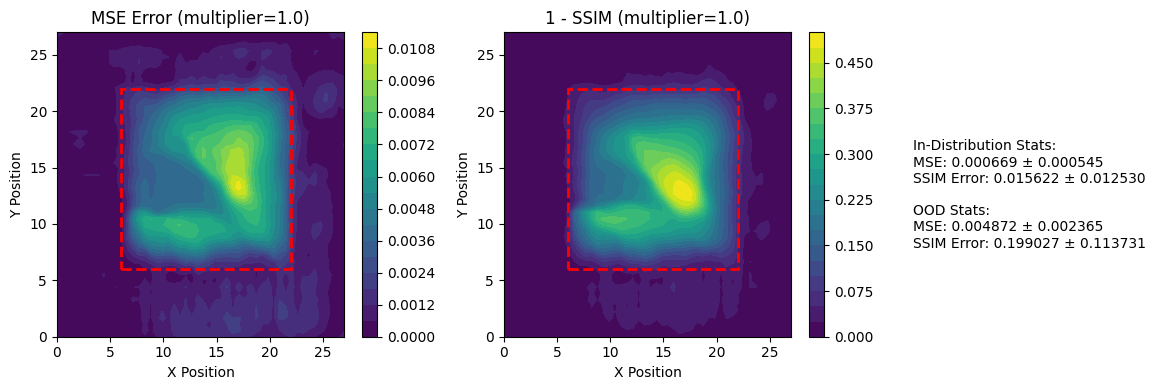


Error Statistics for multiplier 1.0:
In Distribution:
Mean MSE: 0.000669
Std MSE: 0.000545
Mean SSIM Error: 0.015622
Std SSIM Error: 0.012530

Out of Distribution:
Mean MSE: 0.004872
Std MSE: 0.002365
Mean SSIM Error: 0.199027
Std SSIM Error: 0.113731


In [5]:
X, Y, mse_errors, ssim_errors = analyze_2d_reconstruction_error(model)

### Square hold-out visualization (only use this if you trained model with square holdout)

Mean Squared Error on Evaluation: 0.0109


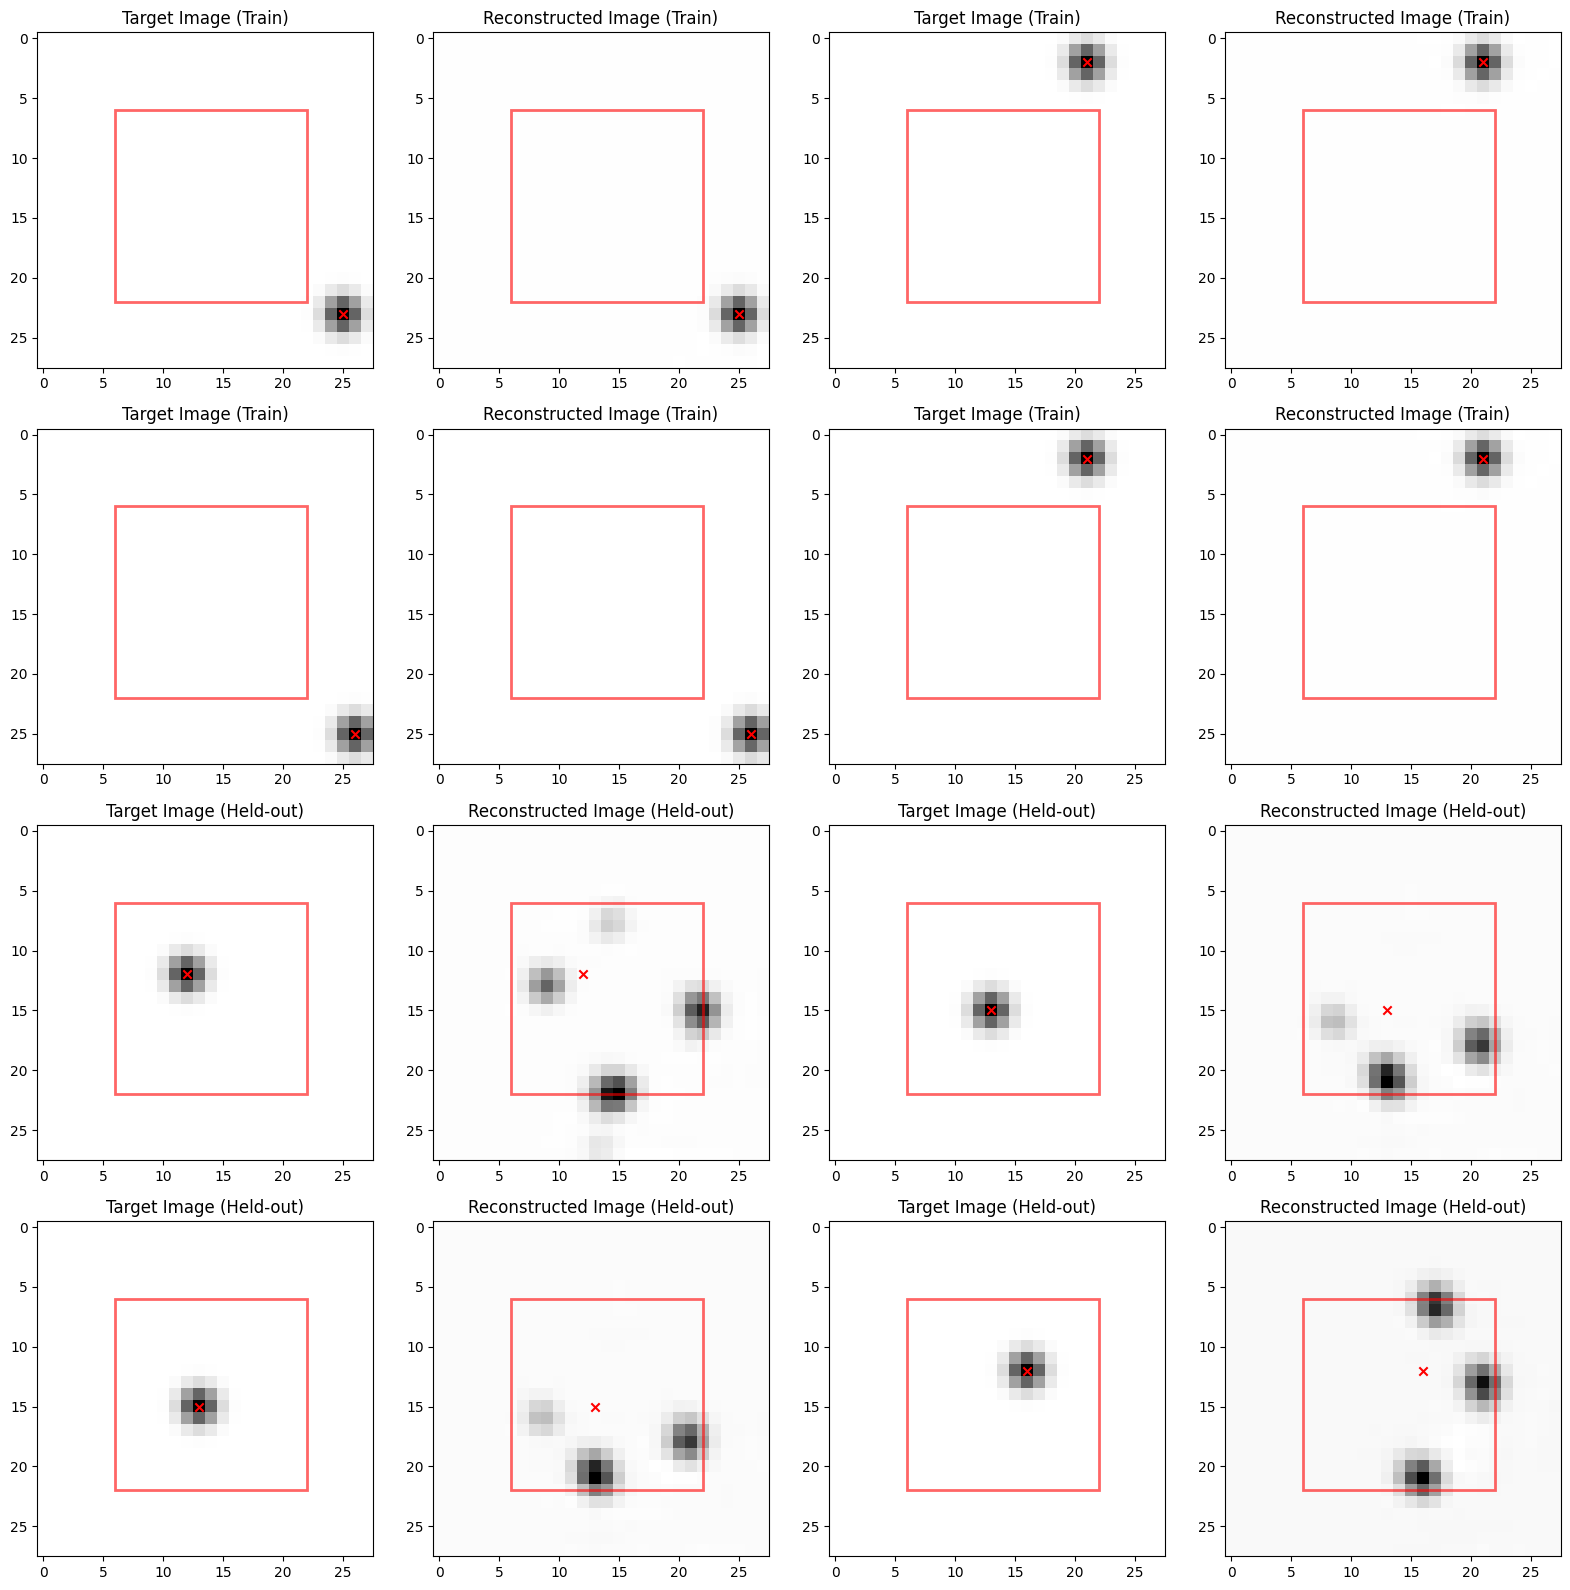

In [7]:
# Dataset and DataLoader for Training (excluding center 6x6 region)
# train_dataset = GaussianBumpDataset(num_samples=1000, grid_size=28, only_holdout=True)
train_dataset = GaussianBumpDatasetSquare(num_samples=1000, grid_size=28, holdout_center=True, heldout_range=[6,22])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Dataset and DataLoader for Evaluation (only center 6x6 region)
eval_dataset = GaussianBumpDatasetSquare(num_samples=100, grid_size=28, only_holdout=True, heldout_range=[12,16])
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
mse_loss = 0.0
criterion = nn.MSELoss()
num_samples = 4
sampled_inputs, sampled_targets, sampled_outputs = [], [], []
train_sampled_inputs, train_sampled_targets, train_sampled_outputs = [], [], []

with torch.no_grad():
    # Evaluate on held-out data (center 6x6 region)
    for batch_idx, (inputs, targets) in enumerate(eval_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        mse_loss += criterion(outputs, targets).item() * inputs.size(0)

        if len(sampled_inputs) < num_samples:
            sampled_inputs.append(inputs.cpu())  # Move to CPU for visualization
            sampled_targets.append(targets.cpu())
            sampled_outputs.append(outputs.cpu())

    # Sample from training distribution
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        if len(train_sampled_inputs) < num_samples:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            train_sampled_inputs.append(inputs.cpu())  # Move to CPU for visualization
            train_sampled_targets.append(targets.cpu())
            train_sampled_outputs.append(outputs.cpu())
        else:
            break

mse_loss /= len(eval_dataloader.dataset)
print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")

x_coord = 6
y_coord = 6
length_x = 22-6
length_y = 22-6

# Plot sampled images
plt.figure(figsize=(16, 16))
for i in range(len(train_sampled_inputs)):
    input_coords = train_sampled_inputs[i][0].numpy()
    target_image = train_sampled_targets[i][0].squeeze().numpy()
    output_image = train_sampled_outputs[i][0].squeeze().numpy()

    x, y = input_coords  # x and y are already in input_coords

    plt.subplot(4, 4, 2 * i + 1)
    plt.title("Target Image (Train)")
    plt.imshow(target_image, cmap='gray')
    plt.scatter([x], [y], color='red', marker='x')
    plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

    plt.subplot(4, 4, 2 * i + 2)
    plt.title("Reconstructed Image (Train)")
    plt.imshow(output_image, cmap='gray')
    plt.scatter([x], [y], color='red', marker='x')
    plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

for i in range(len(sampled_inputs)):
    input_coords = sampled_inputs[i][0].numpy()
    target_image = sampled_targets[i][0].squeeze().numpy()
    output_image = sampled_outputs[i][0].squeeze().numpy()

    x, y = input_coords  # x and y are already in input_coords

    plt.subplot(4, 4, 8 + 2 * i + 1)
    plt.title("Target Image (Held-out)")
    plt.imshow(target_image, cmap='gray')
    plt.scatter([x], [y], color='red', marker='x')
    plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

    plt.subplot(4, 4, 8 + 2 * i + 2)
    plt.title("Reconstructed Image (Held-out)")
    plt.imshow(output_image, cmap='gray')
    plt.scatter([x], [y], color='red', marker='x')
    plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

plt.tight_layout()
plt.show()


### Cross holdout visualization (use only if you had trained model with cross heldout)

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Script to sample labels from different OOD regions and generate images
def generate_ood_samples(model, sample_range=[11, 17], grid_size=28, sigma=1.0):
    model.eval()
    num_samples = 10

    plt.figure(figsize=(20, 8))
    with torch.no_grad():
        # First row: Sample from vertical rectangle (x within 11 to 17, y outside 11 to 17)
        for i in range(num_samples):
            while True:
                x = np.random.randint(sample_range[0], sample_range[1])
                y = np.random.choice(list(range(sample_range[0])) + list(range(sample_range[1], grid_size)))
                if not (sample_range[0] <= y < sample_range[1]):
                    break

            gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * sigma ** 2))
            gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * sigma ** 2))
            # latent_vector = np.concatenate((gaussian_x, gaussian_y))
            latent_vector = np.array([x, y])
            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)

            output_image = model(latent_tensor).cpu().squeeze().numpy()

            plt.subplot(3, 10, i + 1)
            plt.title("Vertical")
            plt.gca().add_patch(plt.Rectangle(
                (sample_range[0], 0), sample_range[1]-sample_range[0], 28, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            plt.gca().add_patch(plt.Rectangle(
                (0, sample_range[0]), 28, sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            # plt.gca().add_patch(plt.Rectangle(
            #     (sample_range[0], 0), sample_range[1]-sample_range[0], sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            # plt.gca().add_patch(plt.Rectangle(
            #     (sample_range[0], sample_range[1]), sample_range[1]-sample_range[0], sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            plt.imshow(output_image, cmap='gray')
            predicted_center = np.unravel_index(np.argmax(1.0 - output_image), output_image.shape)
            plt.scatter([predicted_center[1]], [predicted_center[0]], color='blue', marker='o')
            plt.scatter([x], [y], color='red', marker='x')

        # Second row: Sample from horizontal rectangle (y within 11 to 17, x outside 11 to 17)
        for i in range(num_samples):
            while True:
                y = np.random.randint(sample_range[0], sample_range[1])
                x = np.random.choice(list(range(sample_range[0])) + list(range(sample_range[1], grid_size)))
                if not (sample_range[0] <= x < sample_range[1]):
                    break

            gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * sigma ** 2))
            gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * sigma ** 2))
            # latent_vector = np.concatenate((gaussian_x, gaussian_y))
            latent_vector = np.array([x, y])

            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)

            output_image = model(latent_tensor).cpu().squeeze().numpy()

            plt.subplot(3, 10, 10 + i + 1)
            plt.title("Horizontal")
            plt.gca().add_patch(plt.Rectangle(
                (sample_range[0], 0), sample_range[1]-sample_range[0], 28, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            plt.gca().add_patch(plt.Rectangle(
                (0, sample_range[0]), 28, sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            # plt.gca().add_patch(plt.Rectangle(
            #     (0, sample_range[0]), sample_range[0], sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            # plt.gca().add_patch(plt.Rectangle(
            #     (sample_range[1], sample_range[0]), sample_range[0], sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            plt.imshow(output_image, cmap='gray')
            predicted_center = np.unravel_index(np.argmax(1.0 - output_image), output_image.shape)
            plt.scatter([predicted_center[1]], [predicted_center[0]], color='blue', marker='o')
            plt.scatter([x], [y], color='red', marker='x')

        # Third row: Sample from intersection (x within 11 to 17, y within 11 to 17)
        for i in range(num_samples):
            x = np.random.randint(sample_range[0], sample_range[1])
            y = np.random.randint(sample_range[0], sample_range[1])

            gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * sigma ** 2))
            gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * sigma ** 2))
            # latent_vector = np.concatenate((gaussian_x, gaussian_y))
            latent_vector = np.array([x, y])

            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)

            output_image = model(latent_tensor).cpu().squeeze().numpy()

            plt.subplot(3, 10, 20 + i + 1)
            plt.title("Intersection")
            plt.gca().add_patch(plt.Rectangle(
                (sample_range[0], 0), sample_range[1]-sample_range[0], 28, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            plt.gca().add_patch(plt.Rectangle(
                (0, sample_range[0]), 28, sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            plt.gca().add_patch(plt.Rectangle(
                (sample_range[0], sample_range[0]), sample_range[1]-sample_range[0], sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            plt.imshow(output_image, cmap='gray')
            predicted_center = np.unravel_index(np.argmax(1.0 - output_image), output_image.shape)
            plt.scatter([predicted_center[1]], [predicted_center[0]], color='blue', marker='o')
            plt.scatter([x], [y], color='red', marker='x')

    plt.tight_layout()
    plt.show()

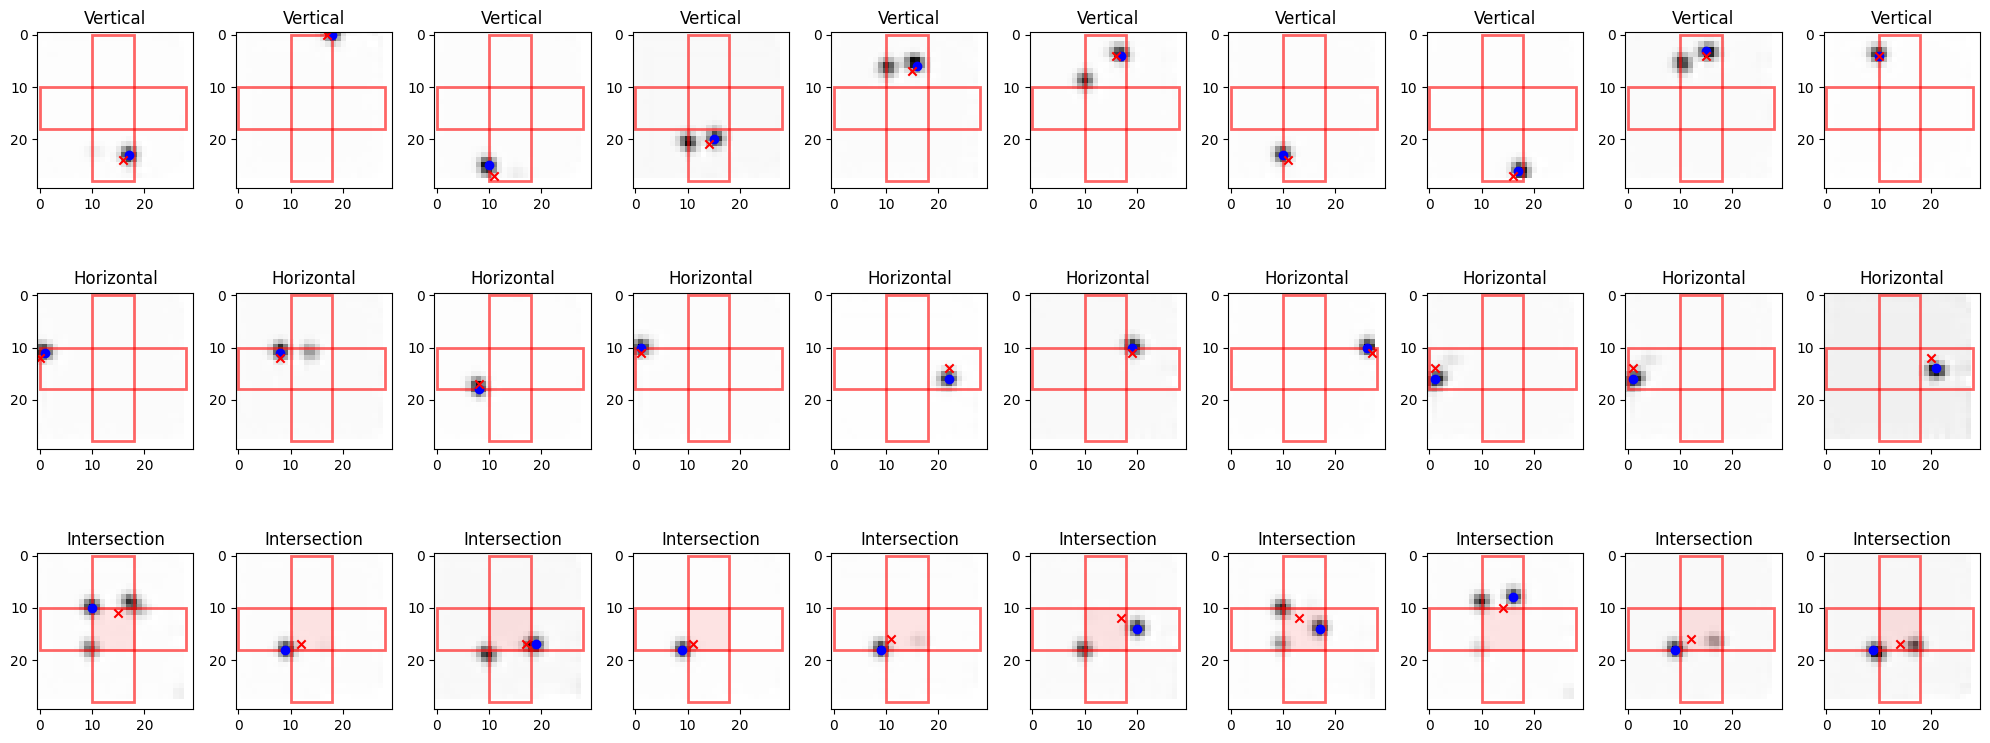

In [30]:
generate_ood_samples(model, sample_range=[10,18])

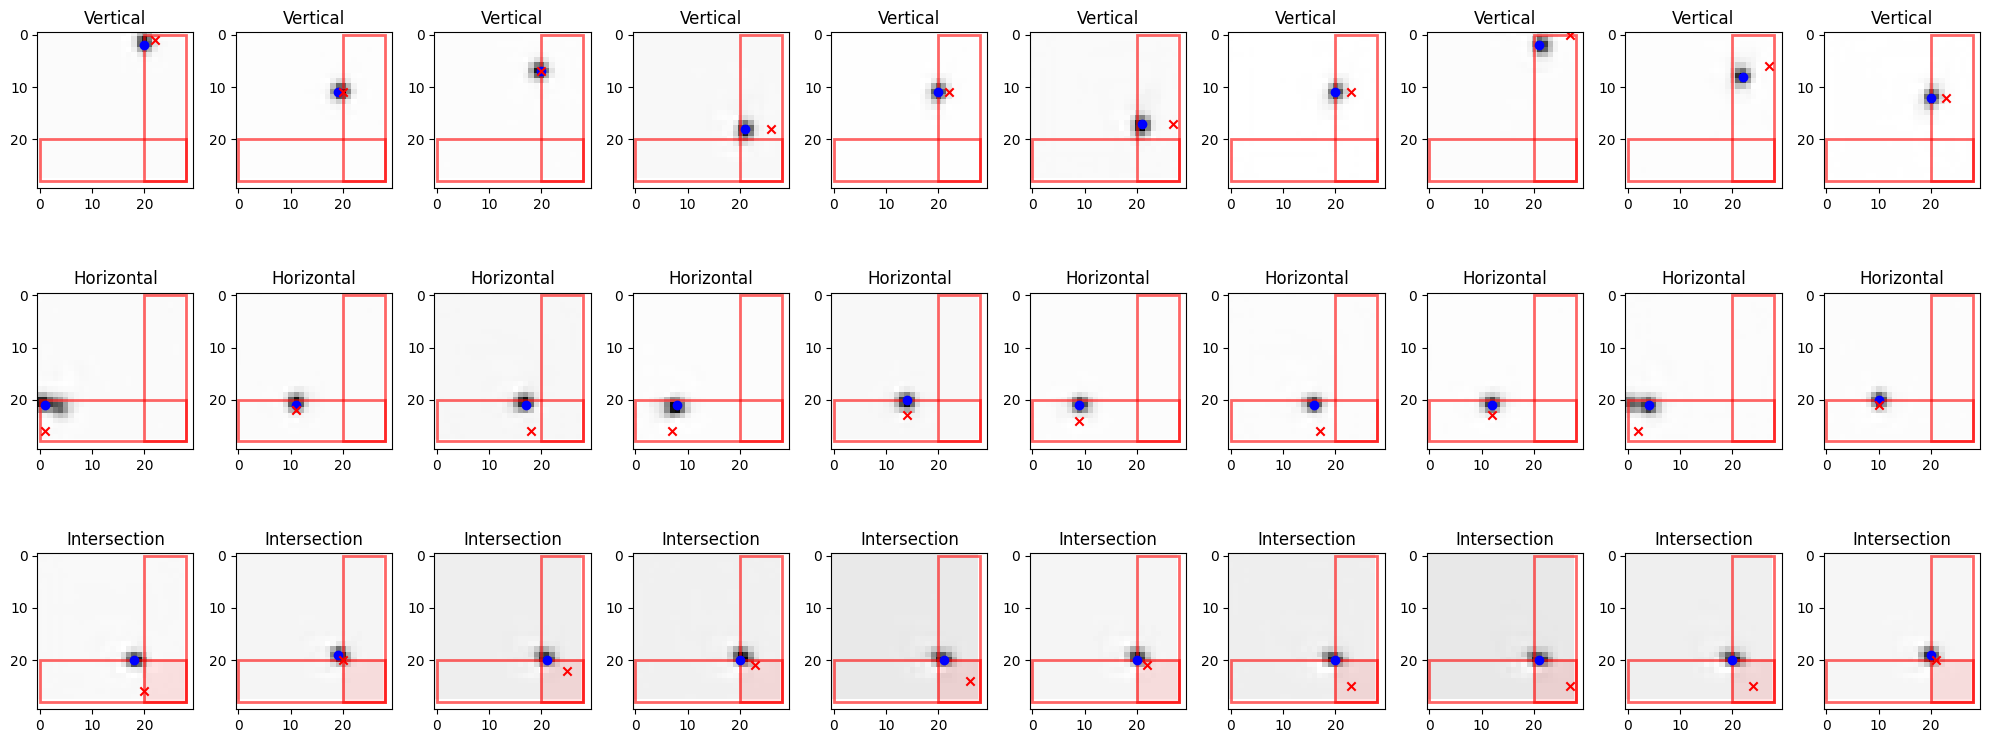

In [28]:
generate_ood_samples(model, sample_range=[20,28])

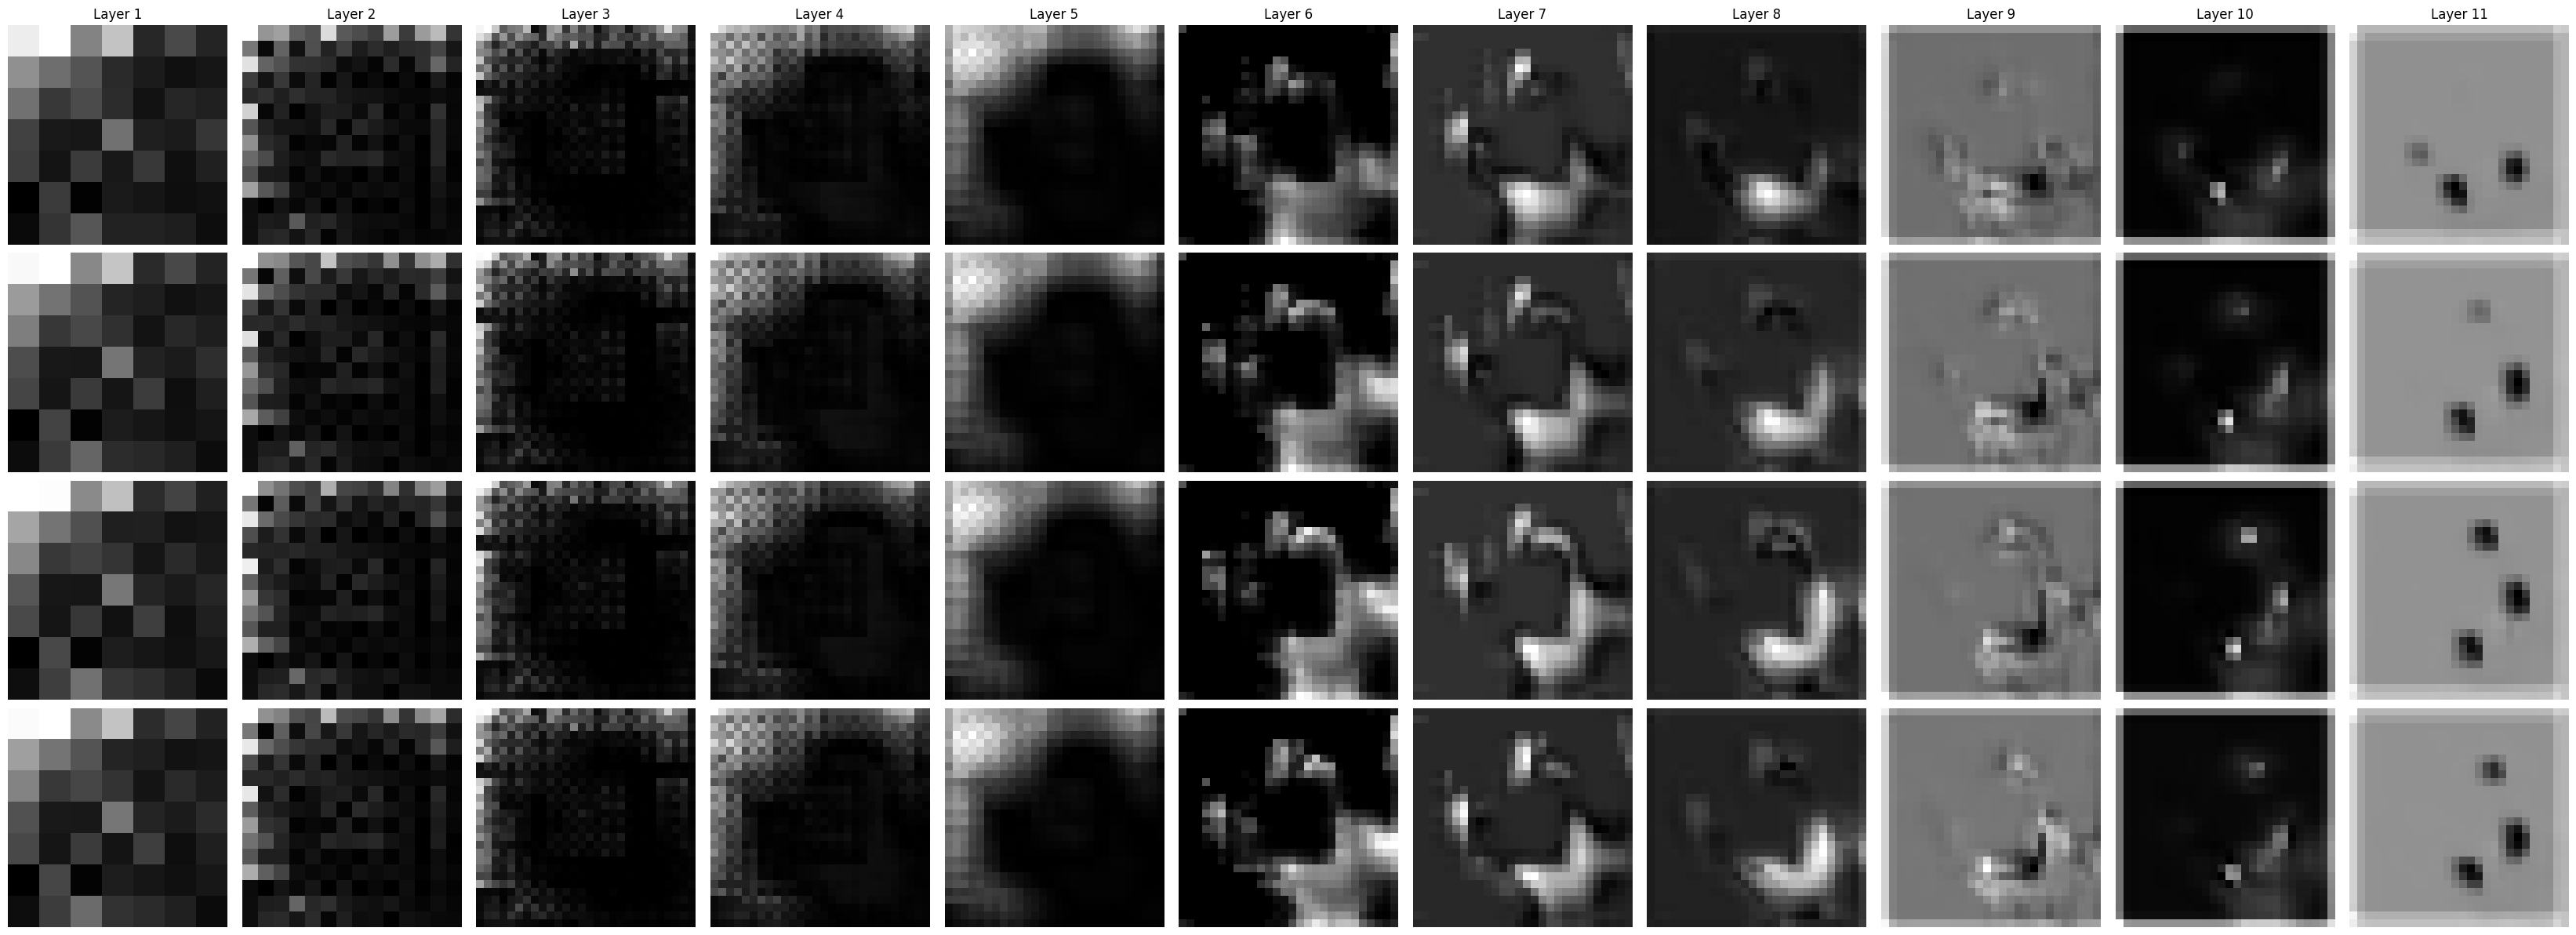

In [6]:
def visualize_layers(model, train_dataloader, device=torch.device('cuda')):
    model.eval()
    criterion = nn.MSELoss()
    num_samples = 4  # Number of samples to visualize
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []
    sampled_activations = []

    with torch.no_grad():
        # Collect samples from training data
        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Collect activations
            activations = [activation.clone().detach().cpu() for activation in model.activations]
            if len(sampled_inputs) < num_samples:
                sampled_inputs.append(inputs.cpu())
                sampled_targets.append(targets.cpu())
                sampled_outputs.append(outputs.cpu())
                # Store activations for the first sample in the batch
                sampled_activation_per_sample = [activation[0] for activation in activations]  # List of tensors
                sampled_activations.append(sampled_activation_per_sample)
            else:
                break  # We have collected enough samples

    # Now we have num_samples samples and their activations
    num_layers = len(sampled_activations[0])  # Number of activations collected

    # Create a grid of plots
    fig, axes = plt.subplots(num_samples, num_layers, figsize=(num_layers * 3, num_samples * 3))

    for i in range(num_samples):
        activations = sampled_activations[i]
        for j in range(num_layers):
            activation = activations[j]  # Shape: (channels, height, width)
            # Compute mean over channels to get a single image
            activation_image = activation.mean(dim=0).numpy()
            # Normalize the activation image for better visualization
            activation_image -= activation_image.min()
            activation_image /= activation_image.max() + 1e-8  # Avoid division by zero
            ax = axes[i, j]
            ax.imshow(activation_image, cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Layer {j+1}')
    plt.tight_layout()
    plt.show()

visualize_layers(model, eval_dataloader)